In [4]:
# Install Gradio for the interactive dashboard
!pip install gradio

In [16]:
import zipfile
import io
import os
import shutil # Added for rmtree

print("Please upload your dataset.zip file")
uploaded = files.upload()

base_dir = 'cow_data_local'

# Clear the base directory if it exists to ensure a clean start
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(base_dir, exist_ok=True) # Create base_dir

print("Unzipping files...")
for zip_name, content in uploaded.items(): # Iterate over all uploaded zip files
    # Attempt to derive class name from zip file name
    # e.g., 'hcaugmented' from 'hcaugmented-20251114T125321Z-1-001.zip'
    class_name_parts = zip_name.split('-')[0].split('.')
    class_name = class_name_parts[0] if class_name_parts else "unknown_class"

    # Create a specific directory for this class inside base_dir
    class_dir = os.path.join(base_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    with zipfile.ZipFile(io.BytesIO(content), 'r') as zf:
        # Determine if the zip contains a single root directory (e.g., 'hcaugmented/...')
        members = zf.namelist()
        if members and '/' in members[0]:
            # Check if all members share a common directory prefix
            first_member_parts = members[0].split('/')
            common_prefix = first_member_parts[0] + '/'

            if all(m.startswith(common_prefix) for m in members):
                # Extract contents of the root directory into class_dir
                for member in members:
                    if member.startswith(common_prefix) and len(member) > len(common_prefix):
                        target_file_path = os.path.join(class_dir, member[len(common_prefix):])
                        os.makedirs(os.path.dirname(target_file_path), exist_ok=True)
                        if not member.endswith('/'): # If it's a file, not a directory
                            with zf.open(member) as source, open(target_file_path, 'wb') as target:
                                shutil.copyfileobj(source, target)
                print(f"Extracted contents of '{common_prefix}' from {zip_name} to {class_dir}")
            else: # Mixed content or no consistent root directory, extract all directly
                zf.extractall(class_dir)
                print(f"Extracted all from {zip_name} to {class_dir} (assuming mixed/inconsistent structure)")
        else: # Zip file contains images directly at its root
            zf.extractall(class_dir)
            print(f"Extracted all from {zip_name} to {class_dir} (assuming flat structure)")

print(f"All files unzipped to '{base_dir}' with class subdirectories.")

# Set this as your base directory for the next step
# base_dir = 'cow_data_local'

Please upload your dataset.zip file


Saving hcaugmented-20251114T125321Z-1-001.zip to hcaugmented-20251114T125321Z-1-001 (1).zip
Saving lcaugmented-20251114T125417Z-1-001.zip to lcaugmented-20251114T125417Z-1-001 (1).zip
Unzipping files...
Extracted contents of 'hcaugmented/' from hcaugmented-20251114T125321Z-1-001 (1).zip to cow_data_local/hcaugmented
Extracted contents of 'lcaugmented/' from lcaugmented-20251114T125417Z-1-001 (1).zip to cow_data_local/lcaugmented
All files unzipped to 'cow_data_local' with class subdirectories.


In [18]:
import tensorflow as tf
import os

# --- Configuration ---
# Update this path to point to the folder you created in Step 2
# It will most likely be this:
base_dir = 'cow_data_local'

IMAGE_SIZE = (224, 224) # Use 224x224 for models like MobileNetV2
BATCH_SIZE = 32
# --- End Configuration ---

# Load the dataset and split it into training (80%) and validation (20%)
print("Loading training data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=1337, # Seed for reproducibility
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

print("Loading validation data...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

# Get the class names (e.g., ['Healthy', 'Lumpy_augmented'])
class_names = train_ds.class_names
print(f"\nFound classes: {class_names}")

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Loading training data...
Found 2513 files belonging to 2 classes.
Using 2011 files for training.
Loading validation data...
Found 2513 files belonging to 2 classes.
Using 502 files for validation.

Found classes: ['hcaugmented', 'lcaugmented']


In [19]:
# Create a data augmentation layer
# This applies random flips and rotations to make the model more robust
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Load the pre-trained MobileNetV2 model
# We set `include_top=False` to remove its final classification layer
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model layers
base_model.trainable = False

# Build our new model on top
inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs) # Apply augmentation first
x = tf.keras.applications.mobilenet_v2.preprocess_input(x) # Preprocess for MobileNetV2
x = base_model(x, training=False) # Run in inference mode
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Pool features
x = tf.keras.layers.Dropout(0.2)(x) # Regularization

# Our final output layer:
# Dense(1) and 'sigmoid' activation for binary (2-class) classification
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', # Perfect for yes/no (binary) problems
    metrics=['accuracy']
)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Starting model training...
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9301 - loss: 0.1531 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 1.0000 - loss: 6.9760e-04 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 1.0000 - loss: 9.2397e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 1.0000 - loss: 4.2429e-04 - val_accuracy: 1.0000 - val_loss: 9.2999e-04
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 1.0

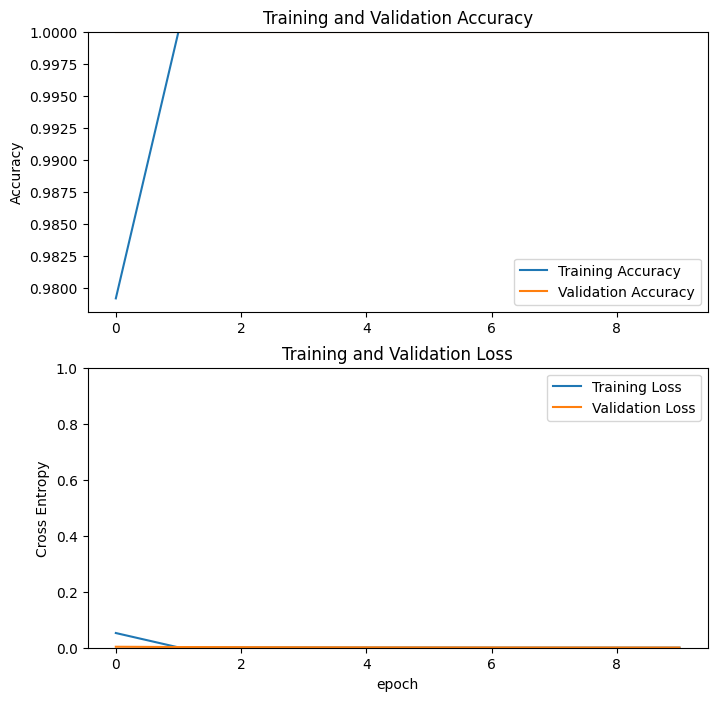

In [14]:
EPOCHS = 10 # You can increase this for better accuracy

print("Starting model training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)
print("Training complete.")

# Optional: Plot training history
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
import gradio as gr
import numpy as np
from PIL import Image

# Use the class_names we found in Step 3
# Ensure consistent display labels regardless of class_names order.
# The model's sigmoid output (prediction) is the probability of the class with label 1.
# tf.keras.utils.image_dataset_from_directory assigns labels alphabetically.
# So if class_names = ['hcaugmented', 'lcaugmented'], then 'hcaugmented' gets label 0 and 'lcaugmented' gets label 1.
# Therefore, `prediction_prob_of_class1` will be the probability of 'lcaugmented' (Lumpy Disease).

# Create a mapping from internal class_name to user-friendly display name
user_friendly_names_map = {
    'hcaugmented': 'Healthy',
    'lcaugmented': 'Lumpy Disease'
}

def predict_image(img):
    """Prediction function for the Gradio interface."""
    # Gradio passes a PIL Image. Convert to numpy array.
    img_array = np.array(img)

    # Resize to the model's expected input size
    img_resized = tf.image.resize(img_array, IMAGE_SIZE)

    # Add a batch dimension (model expects 1, 224, 224, 3)
    img_batch = tf.expand_dims(img_resized, 0)

    # Get the prediction. This will be a single value between 0 and 1 (probability of class 1).
    prediction_prob_of_class1 = model.predict(img_batch)[0][0]

    # Determine which class corresponds to label 0 and label 1 based on class_names order
    # (image_dataset_from_directory sorts alphabetically)
    class_0_internal_name = class_names[0]
    class_1_internal_name = class_names[1]

    # Identify which of these is 'healthy' and which is 'lumpy'
    healthy_internal_name = ''
    lumpy_internal_name = ''
    if 'hcaugmented' in class_0_internal_name:
        healthy_internal_name = class_0_internal_name
        lumpy_internal_name = class_1_internal_name
    else: # Assuming class_0_internal_name is 'lcaugmented' then
        lumpy_internal_name = class_0_internal_name
        healthy_internal_name = class_1_internal_name

    # Assign confidence values
    # The `prediction_prob_of_class1` is the probability of `class_1_internal_name`
    if lumpy_internal_name == class_1_internal_name:
        lumpy_confidence = float(prediction_prob_of_class1)
        healthy_confidence = float(1 - prediction_prob_of_class1)
    else: # lumpy_internal_name must be class_0_internal_name
        lumpy_confidence = float(1 - prediction_prob_of_class1)
        healthy_confidence = float(prediction_prob_of_class1)

    # Prepare the output dictionary using user-friendly names
    output_prediction = {
        user_friendly_names_map[lumpy_internal_name]: lumpy_confidence,
        user_friendly_names_map[healthy_internal_name]: healthy_confidence
    }

    return output_prediction


# Create the Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload Cow Image"),
    outputs=gr.Label(num_top_classes=2, label="Prediction"),
    title="🐄 Cow Lumpy Disease Predictor 🐄",
    description="Upload an image of a cow to predict if it is Healthy or has Lumpy Skin Disease. This model uses MobileNetV2 for transfer learning.",
    allow_flagging="never"
)

# Launch the dashboard!
# `debug=True` provides a shareable public link.
iface.launch(debug=True)

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b32b94de40ce845bb0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
